## Введение

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MVRonkin/Deep-Learning-Foundation-Course/blob/main/2024_Demo/AILightingSMP.ipynb)

<img src="https://github.com/MVRonkin/Deep-Learning-Foundation-Course/raw/main/2024_Demo/QRSemSegColab.png">



### Методология __OSEMN__

OSEMN — это общая методология решения задачи в Data Science.

Методология по существу состоит из 5 шагов.
5 шагов могут быть представлены 3 ролями:
* Data Engineer — работа с большими данными, получение, очистка, хранение данных и формирование датасета под требования задачи.
* Data Analyst — анализ задачи от ее технической (бизнес) постановки до ее решения в области data science, а также интерпретация результатов.
* Data Scientist — решение задач на основе данных, в т. ч. обучение моделей ИИ.

К 5 шагам могут быть добавлены еще два, относящиеся к области внедрения результатов. За реализацию этих шагов отвечают т. н. ML Engineers.

<img src="https://github.com/MVRonkin/Deep-Learning-Foundation-Course/raw/main/2024_Demo/OSEMN.png" width="700px">

## Задачи компьютерного зрения

Перечень базовых задач компьютерного зрения включает не только классификацию изображений, но и ряд других задач. Среди которых следует выделить такие как:
* Cемантичесекая сегментация изображений (Semantic segmentation или Image segmentation);
* Обнараужение объектов (Object detection);
* А также обнаружение ориентированных объектов (Oriented Object Detection);
* Сегментацию экземпляров (объектную сегментацию, Instance segmentation);
* Обнаружение ключевых точек (Key points detection);
* Паноптическую сегментцию (Panoptic Segmentation);
* и ряд других задач. Примры решений задач можно найти на соответствующих сайтах, например, [PaperWithCodes](https://paperswithcode.com/area/computer-vision).

<img src="https://github.com/MVRonkin/Deep-Learning-Foundation-Course/raw/main/2024_Demo/auxiliary/CVTasks.png">

# Install package

In [1]:
%%capture
%pip install --upgrade segmentation-models-pytorch lightning albumentations

# Loading data
For this example we will use CamVid dataset. It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

All images have 320 pixels height and 480 pixels width. For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
%%capture
# Download Data
!git clone https://github.com/alexgkendall/SegNet-Tutorial ./data

In [3]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
DATA_DIR = "./data/CamVid/"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

# Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [7]:
import os
import cv2
import numpy as np
import albumentations as A


class SemSegDataset(Dataset):
    CLASSES = ["sky","building","pole","road","pavement", "tree",
        "signsymbol","fence","car","pedestrian","bicyclist","unlabelled",]

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None):
        self.ids = os.listdir(images_dir)
        self.images_paths = [os.path.join(images_dir, x) for x in self.ids]
        self.masks_paths  = [os.path.join(masks_dir, x)  for x in self.ids]
        self.augmentation = augmentation
        self.set_classes(classes)

    def set_classes(self, classes):
        # Always map background ('unlabelled') to 0
        self.background_class = self.CLASSES.index("unlabelled")
        # If specific classes are provided, map them dynamically
        if classes:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = list(range(len(self.CLASSES)))  # Default to all classes
        # Create a remapping dictionary: class value in dataset -> new index (0, 1, 2, ...)
        # Background will always be 0, other classes will be remapped starting from 1.
        self.class_map = {self.background_class: 0}
        self.class_map.update({v: i + 1 for i, v in enumerate(self.class_values) if v != self.background_class})

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.images_paths[idx]), cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask  = cv2.imread(self.masks_paths[idx], 0) # grayscale mode

        mask_remap = np.zeros_like(mask)
        for class_value, new_value in self.class_map.items():
            mask_remap[mask == class_value] = new_value

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask_remap)
            image, mask_remap = sample["image"], sample["mask"]
        image = image.transpose(2, 0, 1) # ToTensorV2()
        return image, mask_remap



In [9]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())

        # If it's an image, plot it as RGB
        if name == "image":
            # Convert CHW to HWC for plotting
            image = image.transpose(1, 2, 0)
            plt.imshow(image)
        else:
            plt.imshow(image, cmap="tab20")
    plt.tight_layout()
    plt.show()

In [13]:
dataset = SemSegDataset(x_train_dir, y_train_dir)
image, mask = dataset[0]
image.shape, mask.shape

((3, 360, 480), (360, 480))

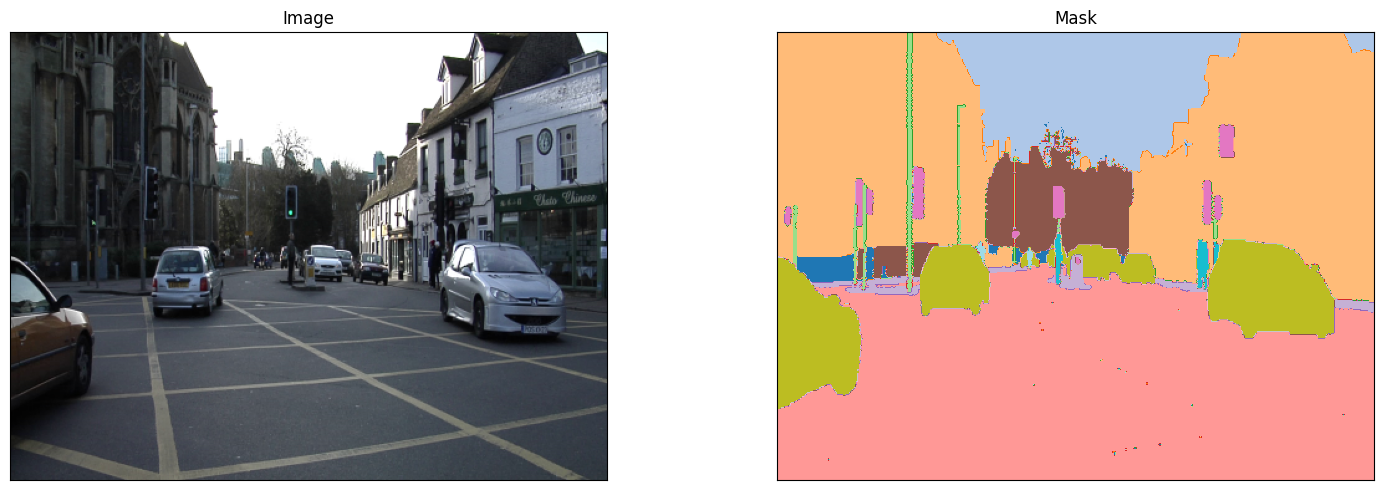

In [14]:
visualize(image=image, mask=mask)

# Augmentations
Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
If you not familiar with such trick read some of these articles:

 - [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:

 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library. For detailed explanation of image transformations you can look at [**kaggle salt segmentation exmaple**](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [15]:
# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        A.RandomCrop(height=320, width=320, always_apply=True),
        # A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf([# A.CLAHE(p=1),
                 A.RandomBrightnessContrast(p=1),
                 A.RandomGamma(p=1),],p=0.9,),
        A.OneOf([A.Sharpen(p=1),
                 A.Blur(blur_limit=3, p=1),
                 A.MotionBlur(blur_limit=3, p=1),],p=0.9,),
        A.OneOf([A.RandomBrightnessContrast(p=1),
                 A.HueSaturationValue(p=1),],p=0.9,),]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480),
    ]
    return A.Compose(test_transform)

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


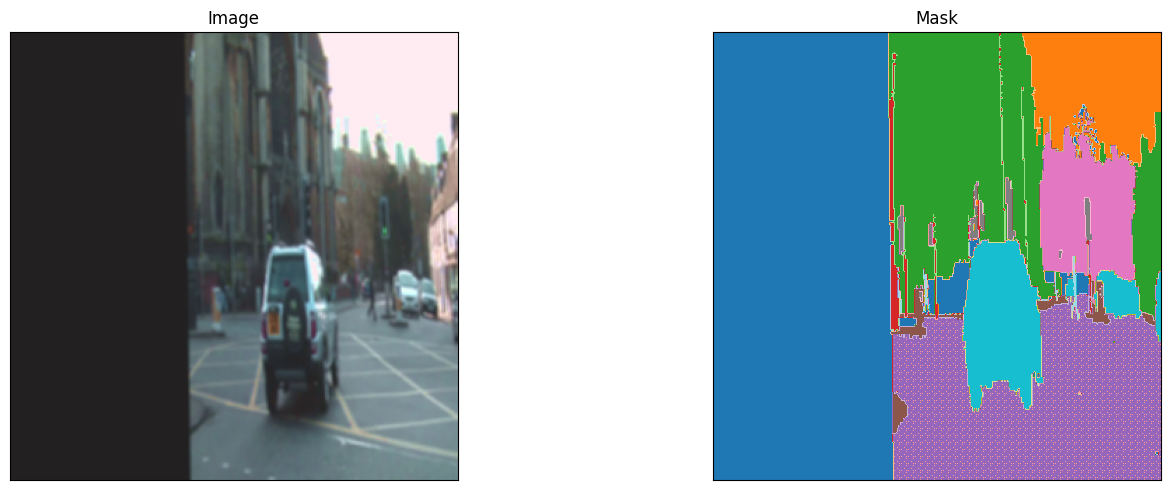

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


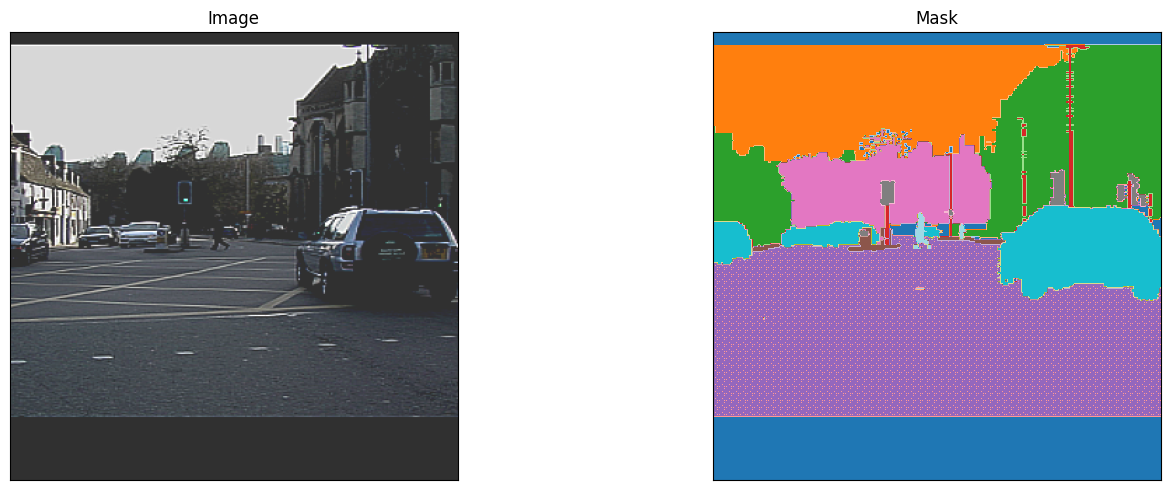

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


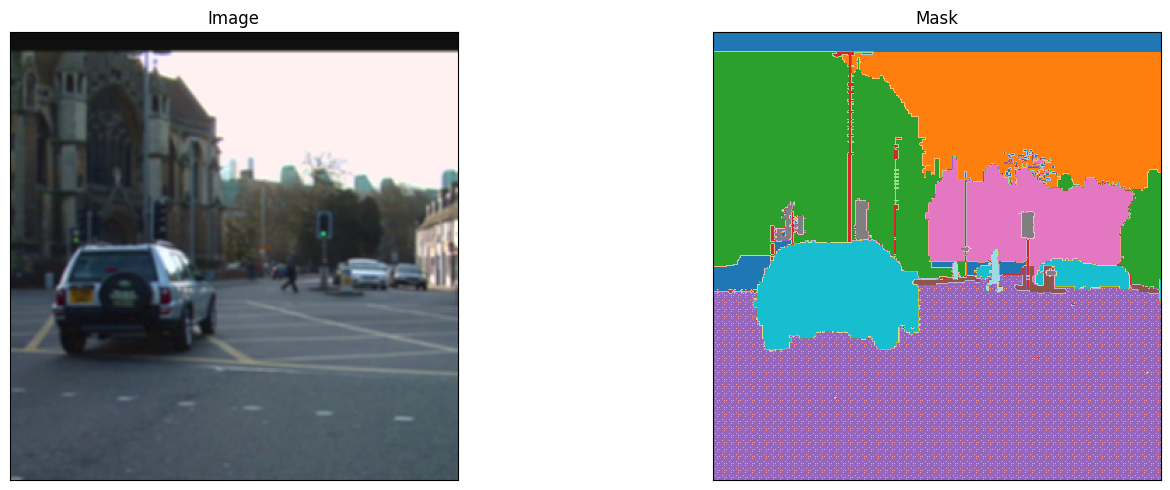

In [17]:
# Visualize resulted augmented images and masks
augmented_dataset = SemSegDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
)

# Visualizing the same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    print(f"Mask shape: {mask.shape}")
    print(np.unique(mask))
    visualize(image=image, mask=mask)

In [18]:
train_dataset = SemSegDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
)

valid_dataset = SemSegDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
)

test_dataset = SemSegDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
)


# g = torch.Generator(device = device)
# Change to > 0 if not on Windows or MacOS machine
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size =8, shuffle=False, num_workers=0)

# Create model and train

In [20]:
# Some training hyperparameters
EPOCHS = 30
T_MAX = EPOCHS * len(train_loader)
# Always include the background as a class
OUT_CLASSES = len(train_dataset.CLASSES)

In [21]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler

class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(arch,encoder_name=encoder_name,
                                      in_channels=in_channels,classes=out_classes,**kwargs,)

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs   = []
        self.validation_step_outputs = []
        self.test_step_outputs       = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch
        mask = mask.long()
        assert image.ndim == 4  # [batch_size, channels, H, W]
        assert mask.ndim == 3  # [batch_size, H, W]

        logits_mask = self.forward(image)

        assert (logits_mask.shape[1] == self.number_of_classes)  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous memory_format
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)
        prob_mask = logits_mask.softmax(dim=1)
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {"loss": loss,"tp": tp,"fp": fp,"fn": fn,"tn": tn,}

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [22]:
model = CamVidModel("FPN", "timm-mobilenetv3_small_075", in_channels=3, out_classes=OUT_CLASSES)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_075-da427f52.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_075-da427f52.pth
100%|██████████| 7.86M/7.86M [00:00<00:00, 92.8MB/s]


In [23]:
!pip install torchinfo
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
CamVidModel                                                  --
├─FPN: 1-1                                                   --
│    └─MobileNetV3Encoder: 2-1                               --
│    │    └─MobileNetV3Features: 3-1                         573,480
│    └─FPNDecoder: 2-2                                       --
│    │    └─Conv2d: 3-2                                      110,848
│    │    └─FPNBlock: 3-3                                    10,496
│    │    └─FPNBlock: 3-4                                    6,400
│    │    └─FPNBlock: 3-5                                    4,352
│    │    └─ModuleList: 3-6                                  1,623,808
│    │    └─MergeBlock: 3-7                                  --
│    │    └─Dropout2d: 3-8                                   --
│    └─SegmentationHead: 2-3                                 --
│    │    └─Conv2d: 3-9                                      1,548
│    

# Training

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 2.3 M  | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.324     Total estimated model params size (MB)
276       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\windows\computer_vision\image_seg\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.744439959526062, 'test_dataset_iou': 0.7414864301681519}]


# Result visualization

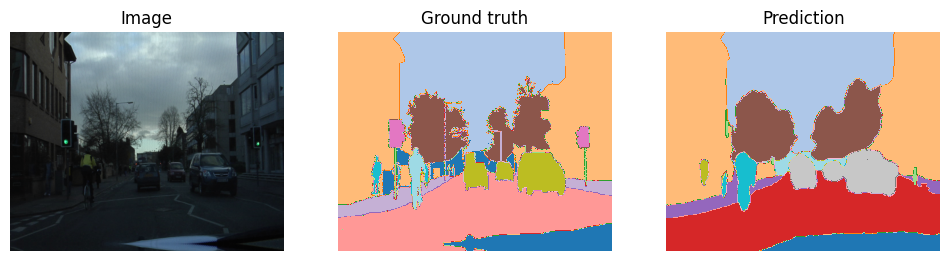

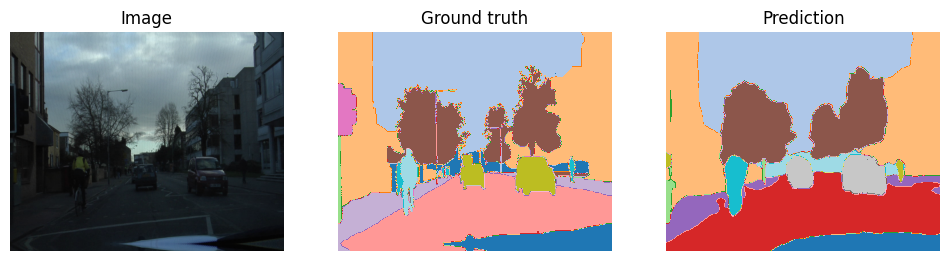

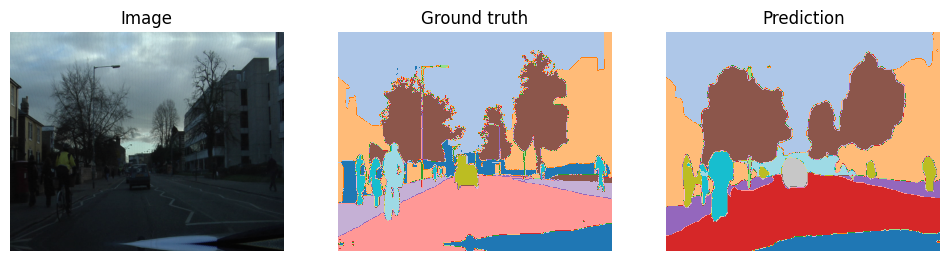

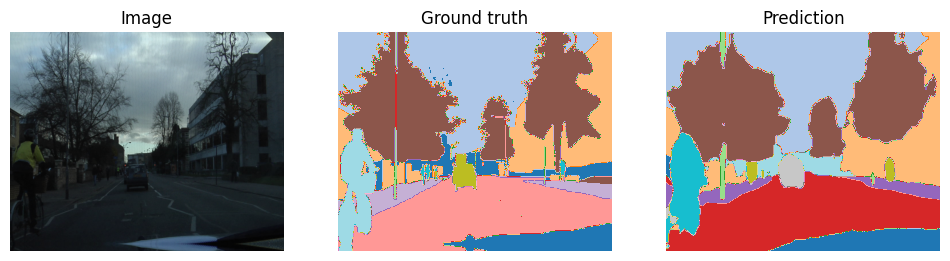

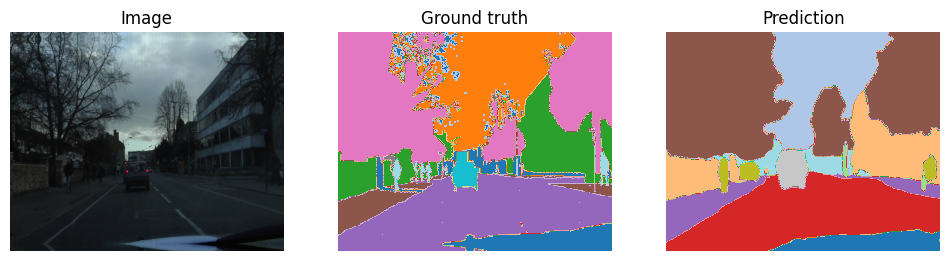

In [ ]:
import numpy as np

# Fetch a batch from the test loader
images, masks = next(iter(test_loader))

# Switch the model to evaluation mode
with torch.no_grad():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break